# Quantum Time Series Analysis: Analysis of results
Compatible with Qiskit 1.2.4+

### Author
- **Jacob Cybulski**, jacob.cybulski[at]deakin.edu.au<br/>
    School of IT, SEBE, Deakin University, Melbourne, Vic, Australia

### Date
- October 2022: Prepared for Workshop on Quantum Machine Learning, 13 October 2022, organised in collaboration with QWorld, QPoland, QIndia and Quantum AI Foundation. In association with IEEE Conference Trends in Quantum Computing and Emerging Business Technologies - TQCEBT 2022
- May 2024: Compatibility upgrade to Qiskit 1.02
- October 2024: Compatibility with Qiskit 1.2.4+ (ML 0.7.2, so no V2)

### Aims
> *This script aims to create a parallel variational model to fit data and provide a forecast.*

### Note
> *<font color="tomato">When running this script, you are likely to obtain slightly different results each time.</font>*

### Primary Sources
- Schuld, Maria, Ryan Sweke, and Johannes Jakob Meyer. 
    "The Effect of Data Encoding on the Expressive Power of Variational Quantum Machine Learning Models." 
    *Physical Review A 103*, no. 3 (March 24, 2021): 032430.<br/> 
    http://arxiv.org/abs/2008.08605<br/>
- PennyLane Dev Team. "Quantum models as Fourier series", Last updated: 15 Jan 2021.<br/>
    https://pennylane.ai/qml/demos/tutorial_expressivity_fourier_series.html

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/miniconda3/envs/qiskit-gpu/lib/python311.zip',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11/site-packages',
 '.']

In [2]:
import numpy as np
import pylab
import math
import json
import time
from tqdm.notebook import tqdm

from IPython.display import clear_output

from utils.Target import *
from utils.Charts import *
from utils.Files import *
from utils.Cost import *

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

In [3]:
### Libraries used in QTSA development

from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit_algorithms.optimizers import L_BFGS_B, P_BFGS, COBYLA, NELDER_MEAD, QNSPSA, ADAM, UMDA
from qiskit.circuit.library import RealAmplitudes, TwoLocal, ZFeatureMap, ZZFeatureMap
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit.visualization import plot_histogram, plot_state_city, plot_state_paulivec
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit.circuit import Parameter
from qiskit.compiler import transpile

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 

## Setup the environment

In [4]:
### Listing control
debug = True

### Software version
MAJOR = 9
MINOR = 0

### Log path constants
LOG_NAME = 'log_2'
DATA_PATH = f'{LOG_NAME}/data'
TRAIN_PATH = f'{LOG_NAME}/training'
PARAMS_PATH = f'{LOG_NAME}/params'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'
FIGURES_PATH = f'{LOG_NAME}/figures'

### Show constants
(LOG_NAME, DATA_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH, FIGURES_PATH)

('log_2',
 'log_2/data',
 'log_2/training',
 'log_2/params',
 'log_2/analysis',
 'log_2/figures')

## Fetch all training meta-data

In [5]:
### Training parameters

### All created files have the following codes:
#   n: sample size
#   z: level of noise injected
#   q: number of qubits
#   l: number of layers
#   opt_name: name of the optimiser
#   ep: number of "maxiter" epochs
train_info_id = 'serial_n70_z0.0_q1_l27_L_BFGS_B_ep40'
train_info_fpath = f'{TRAIN_PATH}/{train_info_id}/info.json'
train_info_fpath

'log_2/training/serial_n70_z0.0_q1_l27_L_BFGS_B_ep40/info.json'

In [6]:
## Fetch all training parameters
### Reading the info file
train_info = read_json_file(train_info_fpath)

print(f'\nLoaded time series from a file "{train_info_fpath}":\n')
for k in train_info.keys():
    print(f'\tinfo[{k}] = {train_info[k]}')
print()

### Get info details
CASE_NAME = train_info['case_name']
DATA_NAME = train_info['data_name']
MAJOR = train_info['major_version'] 
MINOR = train_info['minor_version']
samples = train_info['data_sample']
train_pc = train_info['data_split']
noise = train_info['data_noise']
qubits = train_info['ansatz_qubits']
layers = train_info['ansatz_layers']
log_interv = train_info['log_interv']
opt_name = train_info['opt_name']
epochs = train_info['epochs']
shots = train_info['shots']
seed = train_info['seed']


Loaded time series from a file "log_2/training/serial_n70_z0.0_q1_l27_L_BFGS_B_ep40/info.json":

	info[case_name] = serial
	info[major_version] = 9
	info[minor_version] = 0
	info[data_name] = 2_sins
	info[data_sample] = 70
	info[data_split] = 0.7142857142857143
	info[data_noise] = 0.0
	info[ansatz_qubits] = 1
	info[ansatz_layers] = 27
	info[log_interv] = 1
	info[opt_name] = L_BFGS_B
	info[epochs] = 40
	info[shots] = 10000
	info[seed] = 2022



## Fetch all parameters and history

In [7]:
### Reconstruct training prefix
TRAIN_PREF = f'{CASE_NAME}_n{samples}_z{noise}_q{qubits}_l{layers}_'+\
             f'{opt_name}_'+\
             f'ep{epochs}'
TRAIN_PREF

'serial_n70_z0.0_q1_l27_L_BFGS_B_ep40'

In [8]:
### Training info files 
init_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/init.arr'
history_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/hist.arr'
params_fpath = f'{PARAMS_PATH}/{TRAIN_PREF}/params.arr'
train_info_fpath

'log_2/training/serial_n70_z0.0_q1_l27_L_BFGS_B_ep40/info.json'

In [9]:
### Read training data
init_weights = read_ts_file(init_fpath)
objfun_vals = read_ts_file(history_fpath)
params_vals = read_ts_file(params_fpath)
print(f'Imported data shapes: init_weights={init_weights.shape}; objfun_vals={objfun_vals.shape}; params_vals={params_vals.shape}')

Imported data shapes: init_weights=(84,); objfun_vals=(48,); params_vals=(48, 84)


## Fetch all source data
*Note that this is flat data, so no windows*

In [10]:
### All created files have the following codes:
#   t: training sample size
#   v: validation sample size
#   z: level of noise injected
#   w: window size
#   s: window step size
#   h: horizon size

samples_train = int(samples * train_pc)
samples_valid = samples - samples_train
wind_size = 0
wind_step = 0
horizon = 0
print(f'Data specs: train.shape=({samples_train}, 1), valid.shape=({samples_valid}, 1)')

DATA_PREF = f'{DATA_NAME}_t{samples_train}_v{samples_valid}_z{noise}_w{wind_size}_s{wind_step}_h{horizon}'
DATA_PREF

Data specs: train.shape=(50, 1), valid.shape=(20, 1)


'2_sins_t50_v20_z0.0_w0_s0_h0'

In [11]:
### Define file names

x_all_fpath = f'{DATA_PATH}/{DATA_PREF}/x_all.arr'
y_all_fpath = f'{DATA_PATH}/{DATA_PREF}/y_all.arr'

x_train_fpath = f'{DATA_PATH}/{DATA_PREF}/x_train.arr'
y_train_fpath = f'{DATA_PATH}/{DATA_PREF}/y_train.arr'
x_valid_fpath = f'{DATA_PATH}/{DATA_PREF}/x_valid.arr'
y_valid_fpath = f'{DATA_PATH}/{DATA_PREF}/y_valid.arr'

data_info_fpath = f'{DATA_PATH}/{DATA_PREF}/info.json'
data_info_fpath

'log_2/data/2_sins_t50_v20_z0.0_w0_s0_h0/info.json'

In [12]:
### Load data files
X_all = read_ts_file(x_all_fpath)[..., None]
y_all = read_ts_file(y_all_fpath)
X_train = read_ts_file(x_train_fpath)[..., None]
y_train = read_ts_file(y_train_fpath)
X_valid = read_ts_file(x_valid_fpath)[..., None]
y_valid = read_ts_file(y_valid_fpath)
print(f'\nLoaded time series data\n')


Loaded time series data



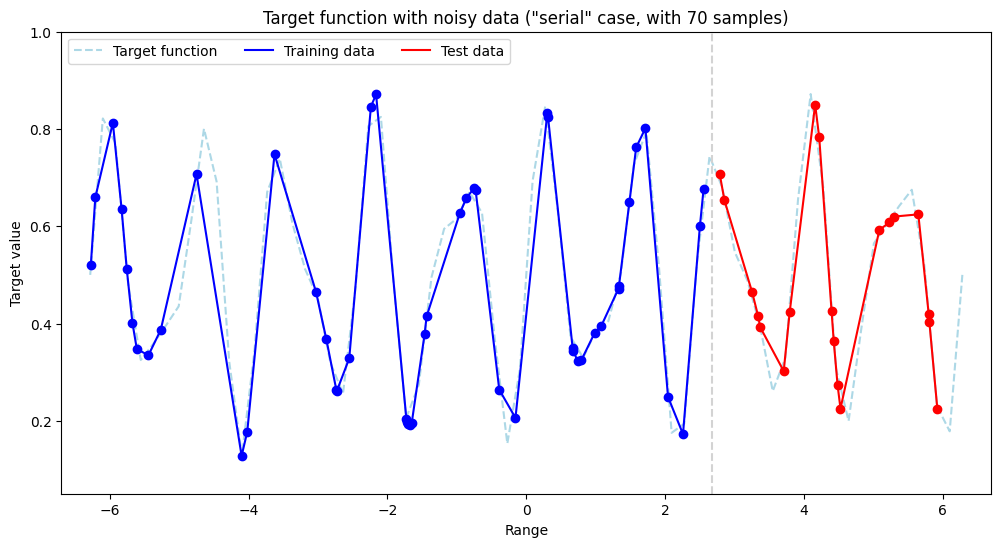

In [13]:
##### Plot data
plot_train_and_test_data(
    X_all, y_all, X_train, y_train, X_valid, y_valid,
    xlim=(-6.7, 6.7), ylim=(0.05, 1),
    colors=['lightblue', 'blue', 'red', 'blue', 'red'], linestyles=['dashed', 'solid', 'solid'],
    title=f'Target function with noisy data ("{CASE_NAME}" case, with {samples} samples)'
)

## Create a parallel model to fit data

### Identify device

In [14]:
##### Find what devices are available
from qiskit_aer import Aer
from qiskit_aer.backends import AerSimulator
devices = AerSimulator().available_devices()
print(f'Available devices:\t{devices}')

### Priority GPU
device = 'GPU' if ('GPU' in devices) else 'CPU'

### Force CPU for this run
device = 'CPU'
print(f'Selected device:\t{device}')

Available devices:	('CPU', 'GPU')
Selected device:	CPU


In [15]:
##### Create a sampler/estimator suitable for the device
#     GPU methods: statevector, tensor_network, density_matrix, unitary

# from qiskit.primitives import StatevectorSampler as Sampler # For "CPU" and ML 0.8.0
# from qiskit.primitives import StatevectorEstimator as Estimator # For "CPU" and ML 0.8.0
from qiskit.primitives import Sampler # For "CPU", ignores device="GPU" option
from qiskit.primitives import Estimator # For "CPU", ignores device="GPU" option
from qiskit_aer.primitives import Sampler as AerSampler, Estimator as AerEstimator # For device="GPU" option

seed = 2022
shots = 10000

if device == 'GPU':
    sampler = AerSampler(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': shots},
        transpile_options={'seed_transpiler': seed},
    )
    
    estimator = AerEstimator(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': shots},
        transpile_options={'seed_transpiler': seed},
    )
else:
    sampler = Sampler()
    estimator = Estimator()

### Create a serial model and test it

Parameters (19): ParameterView([Parameter(W[000]), Parameter(W[001]), Parameter(W[002]), Parameter(W[003]), Parameter(W[004]), Parameter(W[005]), Parameter(W[006]), Parameter(W[007]), Parameter(W[008]), Parameter(W[009]), Parameter(W[010]), Parameter(W[011]), Parameter(W[012]), Parameter(W[013]), Parameter(W[014]), Parameter(W[015]), Parameter(W[016]), Parameter(W[017]), Parameter(X)])



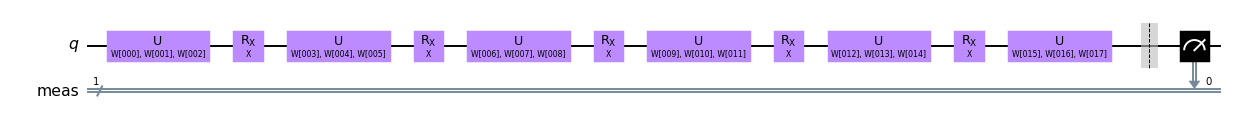

In [16]:
### Create a custom serial model circuit 
#   - To be used with CircuitQNN / NeuralNetworkRegressor

def serial_fourier_model(layers, add_meas=False):
    
    ansatz = QuantumCircuit(1, name="ansatz")
    param_x = Parameter('X')
    pno = 0 # Variational parameter counter
    params = []

    # Data encoding block
    def S():
        ansatz.rx(param_x, 0)

    # Trainable variational block
    def W(layer, label):
        nonlocal pno
        nonlocal params
        param_w_0 = Parameter(f'{label}[{pno:03d}]')
        param_w_1 = Parameter(f'{label}[{pno+1:03d}]')
        param_w_2 = Parameter(f'{label}[{pno+2:03d}]')
        params += [param_w_0, param_w_1, param_w_2]
        ansatz.u(param_w_0, param_w_1, param_w_2, 0)
        pno += 3

    # Create layers of W, S blocks
    for l in range(layers):
        W(l, 'W')
        S()

    # Add the final block
    W(layers, 'W')

    if add_meas:
        ansatz.measure_all()

    # Create a parameter list
    params += [param_x]

    return ansatz 

# Show a sample serial model with the specified number of layers
m = serial_fourier_model(5, add_meas=True)

# Show all parameters, the last is X
print(f'Parameters ({len(m.parameters)}): {m.parameters}')
print()

# Show the circuit
m.draw(output='mpl', style='clifford', scale=0.7, fold=True);

## Analysis and reporting

In [17]:
### Reconstruct training prefix
ANALYSIS_PREF = f'{CASE_NAME}_n{samples}_z{noise}_q{qubits}_l{layers}_'+\
             f'{opt_name}_'+\
             f'ep{epochs}'
ANALYSIS_PREF

'serial_n70_z0.0_q1_l27_L_BFGS_B_ep40'

### Score the model

In [18]:
params_vals.shape

(48, 84)

In [19]:
##### Calculate the scores

### Init scores
train_mae_scores = []
train_mse_scores = []
train_r2_scores = []
test_mae_scores = []
test_mse_scores = []
test_r2_scores = []

### Score calculation and collection
start = time.time()
for param_no in tqdm(range(params_vals.shape[0])):
    
    # Define model, its parameters and their values
    model = serial_fourier_model(layers)
    obs = SparsePauliOp.from_list([("Z" * model.num_qubits, 1)]) 
    sel_weights = params_vals[param_no]
    
    sample_qnn = EstimatorQNN(
        circuit=model,
        input_params=[model.parameters[-1]],
        weight_params=model.parameters[:-1],
        observables=obs,
        estimator=estimator
    )
    
    # Calculate results
    y_train_hat = sample_qnn.forward(X_train, sel_weights)
    y_test_hat = sample_qnn.forward(X_valid, sel_weights)
        
    # Score results
    train_mae = mean_absolute_error(y_train, y_train_hat)
    train_mse = mean_squared_error(y_train, y_train_hat)
    train_r2 = r2_score(y_train, y_train_hat)
    test_mae = mean_absolute_error(y_valid, y_test_hat)
    test_mse = mean_squared_error(y_valid, y_test_hat)
    test_r2 = r2_score(y_valid, y_test_hat)

    # Add scores to their lists
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)
    train_r2_scores.append(train_r2)
    test_mae_scores.append(test_mae)
    test_mse_scores.append(test_mse)
    test_r2_scores.append(test_r2)

elapsed = time.time() - start
print()
print(f'\nThe number of processed parameters: {len(train_mae_scores)}, Time: {np.round(elapsed, 4)} secs\n')

  0%|          | 0/48 [00:00<?, ?it/s]



The number of processed parameters: 48, Time: 4.7371 secs



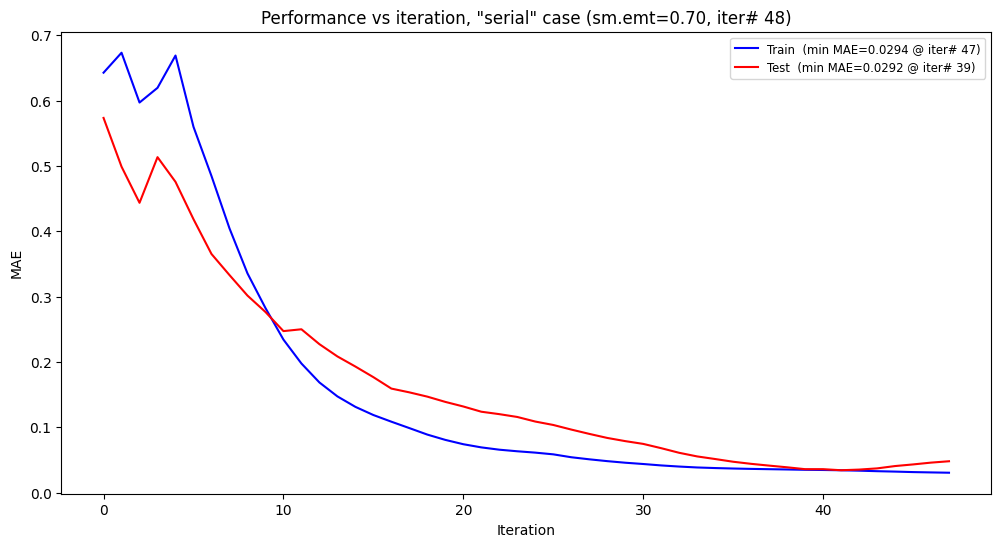

In [20]:
### Plot the MAE score
multi_perform_plot([train_mae_scores, test_mae_scores], log_interv=log_interv, 
    backplot=False, rcParams=(10, 6), dpi=100, smooth_weight=0.7, 
    title=f'Performance vs iteration, "{CASE_NAME}" case', meas_type='MAE', ylabel='MAE', xlabel='Iteration',
    meas_min=True, labels=['Train', 'Test'], line_styles=['solid', 'solid'], line_cols=['blue', 'red'], 
    save_plot=f'{FIGURES_PATH}/analz_{ANALYSIS_PREF}/mae_train_vs_test.eps')

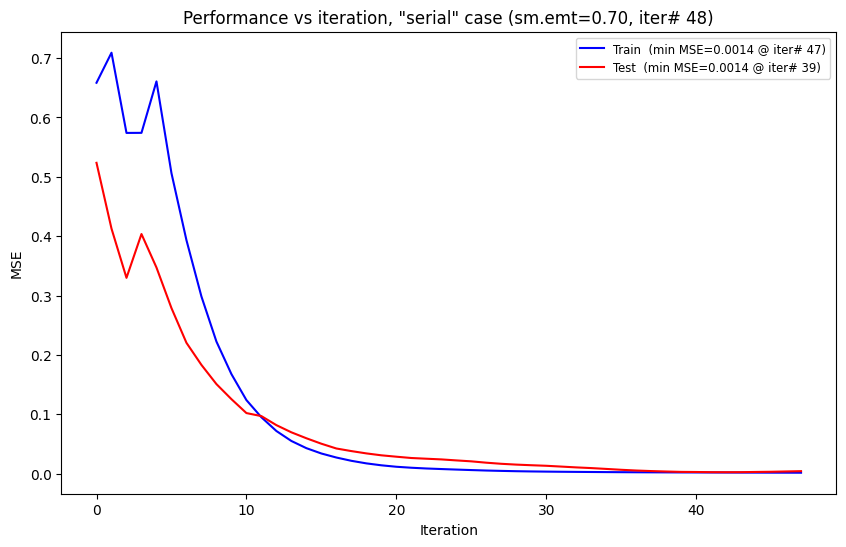

In [21]:
### Plot the MSE score
multi_perform_plot([train_mse_scores, test_mse_scores], log_interv=log_interv, 
    backplot=False, rcParams=(10, 6), dpi=100, smooth_weight=0.7, 
    title=f'Performance vs iteration, "{CASE_NAME}" case', meas_type='MSE', ylabel='MSE', xlabel='Iteration',
    meas_min=True, labels=['Train', 'Test'], line_styles=['solid', 'solid'], line_cols=['blue', 'red'], 
    save_plot=f'{FIGURES_PATH}/analz_{ANALYSIS_PREF}/mse_train_vs_test.eps')

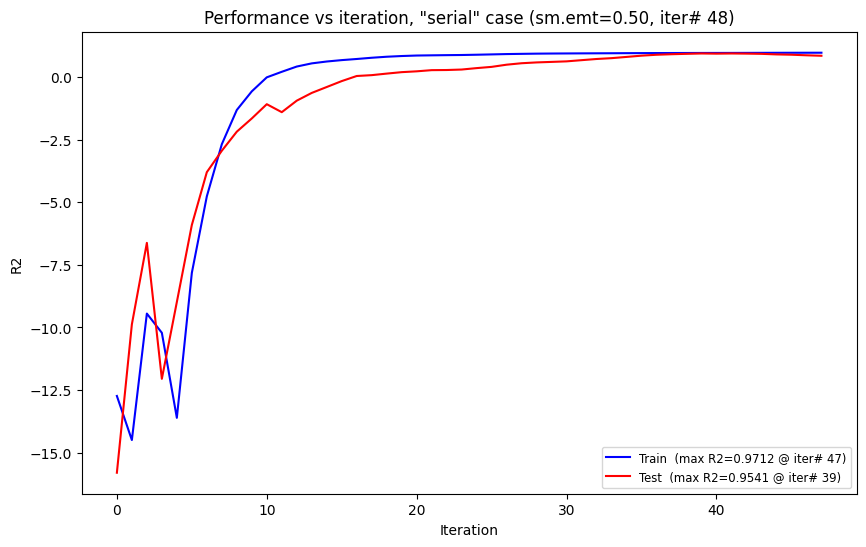

In [22]:
### Plot the R2 score
multi_perform_plot([train_r2_scores, test_r2_scores], log_interv=log_interv, 
    backplot=False, rcParams=(10, 6), dpi=100, smooth_weight=0.5, 
    title=f'Performance vs iteration, "{CASE_NAME}" case', meas_type='R2', ylabel='R2', xlabel='Iteration',
    meas_min=False, labels=['Train', 'Test'], line_styles=['solid', 'solid'], line_cols=['blue', 'red'], 
    save_plot=f'{FIGURES_PATH}/analz_{ANALYSIS_PREF}/r2_train_vs_test.eps')

## Plot the selected fit


The number of test model parameters: 85, Data shape: (50, 1), Time: 0.0858 secs



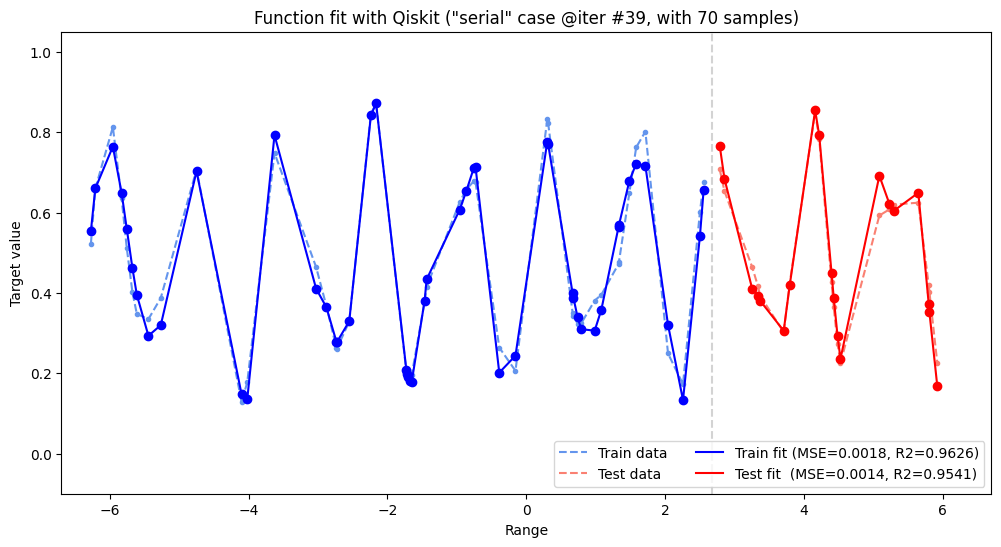

In [23]:
##### Plot selected fit
sel_params_no = 39 // log_interv

### Define model, its parameters and their values
model = serial_fourier_model(layers)
obs = SparsePauliOp.from_list([("Z" * model.num_qubits, 1)]) 
sel_weights = params_vals[sel_params_no]

sample_qnn = EstimatorQNN(
    circuit=model,
    input_params=[model.parameters[-1]],
    weight_params=model.parameters[:-1],
    observables=obs,
    estimator=estimator
)

### Calculate results
start = time.time()
y_train_hat = sample_qnn.forward(X_train, sel_weights)
y_test_hat = sample_qnn.forward(X_valid, sel_weights)
elapsed = time.time() - start

print(f'\nThe number of test model parameters: {model.num_parameters}, Data shape: {X_train.shape}, Time: {np.round(elapsed, 4)} secs\n')

### Score results
train_r2 = np.round(r2_score(y_train, y_train_hat), 4)
train_mse = np.round(mean_squared_error(y_train, y_train_hat), 4)
test_r2 = np.round(r2_score(y_valid, y_test_hat), 4)
test_mse = np.round(mean_squared_error(y_valid, y_test_hat), 4)

### Plot data
plot_train_and_test_data(
    X_all, y_all, X_train, y_train, X_valid, y_valid, y_train_hat, y_test_hat,
    legend_cols=2, legend_loc='lower right', xlim=(-6.7, 6.7), ylim=(-0.1, 1.05), 
    colors=['orange', 'cornflowerblue', 'salmon', 'blue', 'red'], 
    linestyles=['none', 'dashed', 'dashed', 'solid', 'solid'],
    markers=['none', '.', '.', 'o', 'o'],
    title=f'Function fit with Qiskit ("{CASE_NAME}" case @iter #{sel_params_no*log_interv}, with {samples} samples)',
    labels=['Fun', 'Train data', 'Test data', 
            f'Train fit (MSE={train_mse:0.4f}, R2={train_r2:0.4f})', 
            f'Test fit  (MSE={test_mse:0.4f}, R2={test_r2:0.4f})'],
    save_plot=f'{FIGURES_PATH}/analz_{ANALYSIS_PREF}/qiskit_fit_{sel_params_no*log_interv:03}.eps'
)

## Save analysis data

In [24]:
### Training info files 
train_mae_scores_fpath = f'{ANALYSIS_PATH}/{ANALYSIS_PREF}/train_mae_scores.arr'
train_mse_scores_fpath = f'{ANALYSIS_PATH}/{ANALYSIS_PREF}/train_mse_scores.arr'
train_r2_scores_fpath = f'{ANALYSIS_PATH}/{ANALYSIS_PREF}/train_r2_scores.arr'
test_mae_scores_fpath = f'{ANALYSIS_PATH}/{ANALYSIS_PREF}/test_mae_scores.arr'
test_mse_scores_fpath = f'{ANALYSIS_PATH}/{ANALYSIS_PREF}/test_mse_scores.arr'
test_r2_scores_fpath = f'{ANALYSIS_PATH}/{ANALYSIS_PREF}/test_r2_scores.arr'
train_mae_scores_fpath

'log_2/analysis/serial_n70_z0.0_q1_l27_L_BFGS_B_ep40/train_mae_scores.arr'

In [25]:
### Save the scores
write_ts_file(train_mae_scores_fpath, train_mae_scores)
write_ts_file(train_mse_scores_fpath, train_mse_scores)
write_ts_file(train_r2_scores_fpath, train_r2_scores)
write_ts_file(test_mae_scores_fpath, test_mae_scores)
write_ts_file(test_mse_scores_fpath, test_mse_scores)
write_ts_file(test_r2_scores_fpath, test_r2_scores)

## System

In [26]:
!conda env list

# conda environments:
#
base                     /home/jacob/miniconda3
R                        /home/jacob/miniconda3/envs/R
pl                       /home/jacob/miniconda3/envs/pl
pl-cuda12                /home/jacob/miniconda3/envs/pl-cuda12
qiskit                   /home/jacob/miniconda3/envs/qiskit
qiskit-gpu            *  /home/jacob/miniconda3/envs/qiskit-gpu
qiskit100                /home/jacob/miniconda3/envs/qiskit100



In [27]:
!pip list | grep -e qiskit -e scikit

qiskit                    1.2.4
qiskit-aer-gpu            0.15.1
qiskit-algorithms         0.3.1
qiskit-ibm-runtime        0.32.0
qiskit-machine-learning   0.7.2
qiskit-optimization       0.6.1
scikit-learn              1.5.2
